In [1]:
import numpy as np
from matplotlib import pyplot as plt
from pylab import *
from scipy.stats import norm
from scipy.stats import uniform
from astropy.io import fits
from astropy import units as u
import os
from IPython.display import Image
%matplotlib inline

In [518]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn import decomposition
####### following https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-targets-py

### In this notebook, I try to build an GP emulator for the SLICS simulation

In [2]:
########### set the file path ###############
root = '/global/u1/j/jialiu/NGphotoz/'
dir_storage = root+'NGphotoz_scratch/'
dir_cosmos = dir_storage+'Cosmo_maps/'
dir_cov = dir_storage+'Cov_maps/'
dir_bias = dir_storage+'Bias_maps/'

In [321]:
######### photo-z bias parameters
zbias_arr = [0, 0.0003, 0.0007, 0.0015]
sigmaz_arr = [0.01, 0.02, 0.04, 0.06]
out_arr = [0, 0.05, 0.1, 0.15]
theta_g_arr = [1,5,10]

zarr=np.linspace(0,4, 501)
delta_z=0.5
tomo_centers=np.arange(0.5, 3, delta_z)

# Joachime: Parameters are the same for seed_a and seed _f, only the IC differ.
cosmos = [ '%02d_%s'%(i, j) for j in ['a','f'] for i in range(25)]
cosmos += ['fid_a', 'fid_f']
tomo_arr = range(1,6)
cones_bias = arange(1,11)
cones_cov_full = arange(74, 1100)

cones_cosmo = arange(1,6)

pz_lists = genfromtxt(root+'pz_list.txt', dtype='str')
print (cosmos)

['00_a', '01_a', '02_a', '03_a', '04_a', '05_a', '06_a', '07_a', '08_a', '09_a', '10_a', '11_a', '12_a', '13_a', '14_a', '15_a', '16_a', '17_a', '18_a', '19_a', '20_a', '21_a', '22_a', '23_a', '24_a', '00_f', '01_f', '02_f', '03_f', '04_f', '05_f', '06_f', '07_f', '08_f', '09_f', '10_f', '11_f', '12_f', '13_f', '14_f', '15_f', '16_f', '17_f', '18_f', '19_f', '20_f', '21_f', '22_f', '23_f', '24_f', 'fid_a', 'fid_f']


In [25]:
### bias sample fname: biaspz_zbias0_simgaz0.06_outlier0.txt_tomo4_cone10_s10.npy
### Joachim: The LOS number runs from 74 to 1100, with some missing LOS. You will have 954 in total. 
### JL: LOS 140 and 135 are missing, 198 tomo 3, 4 are missing

def stats_gen_true (theta_g, tomo, cone):
    ipz='pz_true.txt'
    fn = dir_bias+'bias%s_tomo%i_cone%s_s%i.npy'%(ipz, tomo, cone, theta_g)
    return np.load(fn)

def stats_gen_bias (izbias, isz, iout, theta_g, tomo, cone):
    ipz='pz_zbias%s_simgaz%s_outlier%s.txt'%(izbias, isz, iout)
    fn = dir_bias+'bias%s_tomo%i_cone%s_s%i.npy'%(ipz, tomo, cone, theta_g)
#     print (fn)
    return np.load(fn)

def stats_gen_cov (theta_g, tomo, cone): #### cone goes from 74 to 1099, missing some, total 953
    fn = dir_cov+'cov_tomo%i_cone%s_s%i.npy'%(tomo, cone, theta_g)
#     print (fn)
    return np.load(fn)

def stats_gen_cosmo (cosmo, theta_g, tomo, cone): 
    fn = dir_cosmos+'/%s_tomo%i_cone%s_s%i.npy'%(cosmo, tomo, cone, theta_g)
#     print (fn)
    return np.load(fn)


In [34]:
array(cosmos).reshape(2,26)

array([['00_a', '01_a', '02_a', '03_a', '04_a', '05_a', '06_a', '07_a',
        '08_a', '09_a', '10_a', '11_a', '12_a', '13_a', '14_a', '15_a',
        '16_a', '17_a', '18_a', '19_a', '20_a', '21_a', '22_a', '23_a',
        '24_a', '00_f'],
       ['01_f', '02_f', '03_f', '04_f', '05_f', '06_f', '07_f', '08_f',
        '09_f', '10_f', '11_f', '12_f', '13_f', '14_f', '15_f', '16_f',
        '17_f', '18_f', '19_f', '20_f', '21_f', '22_f', '23_f', '24_f',
        'fid_a', 'fid_f']], dtype='<U5')

In [35]:
stats_raw = np.array([[[[stats_gen_cosmo(cosmo, theta_g, tomo, cone)
                        for tomo in tomo_arr] ## 5 tomo bins
                        for theta_g in theta_g_arr] ## 3 theta_g
                         for cone in cones_cosmo] ## 5 cones
                        for cosmo in cosmos] ## 52 cosmos 
                       )

print (stats_raw.shape)
## now it is (52, 5, 3, 5, 11, 10), needs to be (26, 10, 3, 5, 11, 10)

(52, 5, 3, 5, 11, 10)


In [37]:
stats_cosmo = concatenate(stats_raw.reshape(2, 26, 5, 3, 5, 11, 10), axis=1)
print (stats_cosmo.shape)
####### axies: 26 cosmo, 10 realizations, 3 smoothing, 5 tomo bins, 11 stats/bin edges, 10 bins

(26, 10, 3, 5, 11, 10)


In [42]:
cosmo_params = np.genfromtxt('CosmoTable.dat')
print (cosmo_params.shape)

IDs, Om_arr, h_arr, w0_arr, si8_arr, Oc_arr = cosmo_params.T 

(26, 6)


In [44]:
Om_arr - Oc_arr ## omega_b is fixed, but not omega_b * h^2

array([0.0473, 0.0473, 0.0473, 0.0473, 0.0473, 0.0473, 0.0473, 0.0473,
       0.0473, 0.0473, 0.0473, 0.0473, 0.0473, 0.0473, 0.0473, 0.0473,
       0.0473, 0.0473, 0.0473, 0.0473, 0.0473, 0.0473, 0.0473, 0.0473,
       0.0473, 0.0473])

In [ ]:
#### 11 columns: ell, ps, ps1, ps2, kappa, peaks, minima, pdf, mf0, mf1, mf2 
def build_emulator(input_arr):
    '''input_arr should have shape (26, 10, x), 
    where 26 is the number of cosmologies, 
    10 is the number of realizations,
    x is the number of bins for the statistic (could be single z or multiple z)'''
    istd = std(input_arr, axis=1)
    imean = mean(input_arr, axis=1)
    

In [495]:
# observations and noise
# input_arr = stats_cosmo[:, :, 1, :, 5, :] ### peak counts, smoothing=5 (index=1), tomo bin =3
# kappa_arr = stats_cosmo[0, 0, 1, :, 4, :]

itomo = 1
ismooth= 1
input_arr = stats_cosmo[:, :, ismooth, itomo, 5, :] ### peak counts, smoothing=5 (index=1), tomo bin = itomo

print ('input_arr.shape:', input_arr.shape)
istd = std(input_arr, axis=1).reshape(26,-1)
imean = mean(input_arr, axis=1).reshape(26,-1)

print (istd.shape, imean.shape, kappa.shape)

input_arr.shape: (26, 10, 10)
(26, 10) (26, 10) (5, 10)


In [497]:
idx=where(imean[-1]>1)[0]
idx=where(amin(imean,axis=0)>1)[0] ## all cosmology has nonzero counts
idx.shape

(7,)

In [498]:
std(X, axis=0)

array([0.12797955, 0.06214928, 0.42997182, 0.21836144])

In [499]:
# Instantiate a Gaussian Process model

kernel = C(1.0, (1e-5, 1e5)) * RBF(std(X, axis=0), length_scale_bounds=(1e-2, 1e2))
              
# parameters
X=cosmo_params[:, 1:-1]
print ('cosmo parameters shape (N_sample, N_feature):', X.shape)

# observations and noise
Y = imean[:,idx]
dY = istd[:,idx]
print ('input_arr.shape:', input_arr.shape)
print ('observations shape (N_sample, N_targets):', Y.shape)
print ('noise shape (N_sample, N_targets):', dY.shape)

Ntest = 25 ## the point to be removed for testing
Xtrue, Ytrue = X[Ntest], Y[Ntest]
Xtest, Ytest, dYtest = [delete(arr, Ntest, axis=0) for arr in [X, Y, dY]]

Xtrue = expand_dims(Xtrue, axis=0)
print (Xtrue)

cosmo parameters shape (N_sample, N_feature): (26, 4)
input_arr.shape: (26, 10, 10)
observations shape (N_sample, N_targets): (26, 7)
noise shape (N_sample, N_targets): (26, 7)
[[ 0.2905  0.6898 -1.      0.8364]]


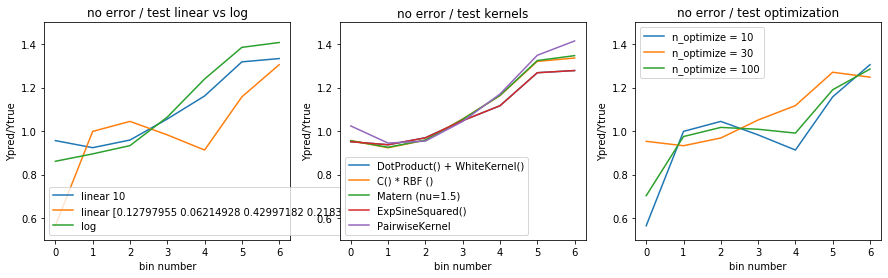

In [500]:
figure(figsize=(15,4))
Xstd=std(X, axis=0)

######## test kernel
subplot(131)
for irbf in [10, Xstd]:#, 10]:
    kernel = C(1, (1e-3, 1e3)) * RBF(irbf, length_scale_bounds=(1e-2, 1e2)) 
    #### length scale up to 10 doesn't matter much
    #### 2nd numbers (1e-5, 1e5) don't seem to do anything
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)#, alpha=idY ** 2)
    gp.fit(Xtest, Ytest)
    Ypred = gp.predict(Xtrue).ravel()
    plot(Ypred/Ytrue, label='linear %s'%(irbf))

########## test log
Ytest_log = log10(Ytest)
kernel = C(1.0, (1e-3, 1e3)) * RBF(1, length_scale_bounds=(1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)
gp.fit(Xtest, Ytest_log)
Ypred = gp.predict(Xtrue).ravel()
plot(10**Ypred/Ytrue, label='log')

title('no error / test linear vs log')
xlabel('bin number')
ylabel('Ypred/Ytrue')
ylim(0.5, 1.5)
legend()


######## test kernel
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, Matern, ExpSineSquared, PairwiseKernel
kernels = [DotProduct() + WhiteKernel(),  C() * RBF (), Matern (nu=1.5), ExpSineSquared(),PairwiseKernel()]
kernel_names = ['DotProduct() + WhiteKernel()',  'C() * RBF ()', 'Matern (nu=1.5)', 'ExpSineSquared()', 'PairwiseKernel']
subplot(132)

for i in range(len(kernels)):
    ikernel = kernels[i]
    ikernel_name = kernel_names[i]
    gp = GaussianProcessRegressor(kernel=ikernel, n_restarts_optimizer=10, normalize_y=True)
    gp.fit(Xtest, Ytest)
    Ypred = gp.predict(Xtrue).ravel()
    plot(Ypred/Ytrue, label='%s'%(ikernel_name))
    
title('no error / test kernels')
xlabel('bin number')
ylabel('Ypred/Ytrue')
ylim(0.5, 1.5)
legend()

####### test optimization -- doesn't matter
subplot(133)
for Nopt in [10, 30, 100]:
    kernel = C(1, (1e-3, 1e3)) * RBF(Xstd, length_scale_bounds=(1e-2, 1e2)) 
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=Nopt, normalize_y=True)#, alpha=idY ** 2)
    gp.fit(Xtest, Ytest)
    Ypred = gp.predict(Xtrue).ravel()
    plot(Ypred/Ytrue, label='n_optimize = %s'%(Nopt))
    
    
title('no error / test optimization')
xlabel('bin number')
ylabel('Ypred/Ytrue')
ylim(0.5, 1.5)
legend()
show()

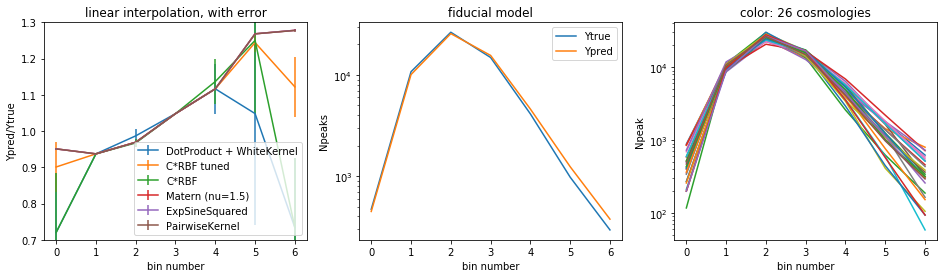

In [501]:
########### build 50 GPs, assuming no correlation between bins
kernels = [DotProduct() + WhiteKernel(), C(1.0, (1e-3, 1e3)) * RBF(Xstd, length_scale_bounds=(1e-2, 1e2)), C() * RBF (), Matern (nu=1.5), ExpSineSquared(),PairwiseKernel()]
kernel_names = ['DotProduct + WhiteKernel',  'C*RBF tuned', 'C*RBF', 'Matern (nu=1.5)', 'ExpSineSquared', 'PairwiseKernel']

figure(figsize=(16,4))
subplot(131)
for i in range(len(kernels)):
    ikernel = kernels[i]
    ikernel_name = kernel_names[i]
    gp_arr = [GaussianProcessRegressor(kernel=ikernel, n_restarts_optimizer=10, alpha=idY**2, normalize_y=True) for idY in dYtest.T]
    gp_run = [gp_arr[i].fit(Xtest, Ytest.T[i]) for i in arange(len(idx))]
    out = [igp.predict(Xtrue, return_std=True) for igp in gp_run]
    Ypred = np.array([iout[0][0] for iout in out])
    Ysigma =np.array([iout[1] for iout in out]).ravel()
#     icolor=rand(3)
    errorbar(arange(len(idx)), Ypred/Ytrue, Ysigma/Ypred, label='%s'%(ikernel_name))#, color=icolor)
#     plt.fill_between(arange(len(idx)), (Ypred-Ysigma)/Ytrue, (Ypred-Ysigma)/Ytrue, alpha=0.5, color=icolor)

title('linear interpolation, with error')
xlabel('bin number')
ylabel('Ypred/Ytrue')
ylim(0.7, 1.3)
legend()

subplot(132)
plot(Ytrue,label='Ytrue')
plot(Ypred,label='Ypred')
xlabel('bin number')
ylabel('Npeaks')
yscale('log')
title('fiducial model')
legend()

subplot(133)
for iimean in imean[:,idx]:
    plot(iimean)
yscale('log')
xlabel('bin number')
ylabel('Npeak')
title('color: 26 cosmologies')

show()

### Next, try: 
### (1) 1 tomo bin (done above) - not helping
### (2) use covariance matrix to get the good error, not the cosmo-varying one - not helping
### (3) PCA
### (4) optimize hyper parameters?

In [506]:
cones_cov_missing = []
for i in range(74, 1100):
    if not os.path.isfile('/global/u1/j/jialiu/NGphotoz/NGphotoz_scratch/Cov_maps/cov_tomo1_cone%i_s5.npy'%(i)):
        cones_cov_missing.append(i)
cones_cov_missing=np.array(cones_cov_missing)
cones_cov = setdiff1d(cones_cov_full, cones_cov_missing)
print (cones_cov.shape)

# stats_cov = np.array([[[stats_gen_cov(theta_g, tomo, cone)
#                         for tomo in tomo_arr] ## 5 tomo bins                        
#                          for cone in cones_cov] ## 5 cones
#                          for theta_g in theta_g_arr] ## 3 theta_g
#                        )

# np.save('/global/u1/j/jialiu/NGphotoz/NGphotoz_scratch/stats_cov.npy', stats_cov)
stats_cov = np.load('/global/u1/j/jialiu/NGphotoz/NGphotoz_scratch/stats_cov.npy')
print (stats_cov.shape)
## in total should be 953 realizations

(953,)
(3, 953, 5, 11, 10)


In [510]:
Ycov = stats_cov[1,:,1, 5, :]
print (Ycov.shape)
Ycov = Ycov.reshape(953,-1)[:,idx]
print (Ycov.shape)
dYcov = std(Ycov, axis=0)
print (dYcov.shape)
Nsim=len(Ycov)
print (Nsim)

(953, 10)
(953, 7)
(7,)
953


### test using error from the covariance batch - not helping

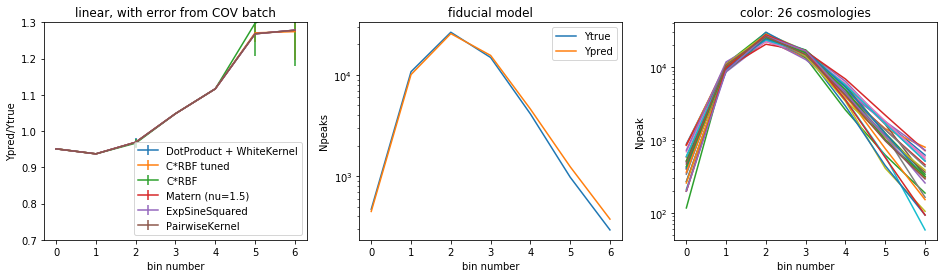

In [514]:
########### build 50 GPs, assuming no correlation between bins
kernels = [DotProduct() + WhiteKernel(), C(1.0, (1e-3, 1e3)) * RBF(Xstd, length_scale_bounds=(1e-2, 1e2)), C() * RBF (), Matern (nu=1.5), ExpSineSquared(),PairwiseKernel()]
kernel_names = ['DotProduct + WhiteKernel',  'C*RBF tuned', 'C*RBF', 'Matern (nu=1.5)', 'ExpSineSquared', 'PairwiseKernel']

figure(figsize=(16,4))
subplot(131)
for i in range(len(kernels)):
    ikernel = kernels[i]
    ikernel_name = kernel_names[i]
    gp_arr = [GaussianProcessRegressor(kernel=ikernel, n_restarts_optimizer=10, alpha=idY**2, normalize_y=True) for idY in dYcov]
    gp_run = [gp_arr[i].fit(Xtest, Ytest.T[i]) for i in arange(len(idx))]
    out = [igp.predict(Xtrue, return_std=True) for igp in gp_run]
    Ypred = np.array([iout[0][0] for iout in out])
    Ysigma =np.array([iout[1] for iout in out]).ravel()
    errorbar(arange(len(idx)), Ypred/Ytrue, Ysigma/Ypred, label='%s'%(ikernel_name))
# errorbar(arange(len(idx)), Ytrue/Ytrue, dYcov/Ytrue, label='variance')#, color=icolor)

title('linear, with error from COV batch')
xlabel('bin number')
ylabel('Ypred/Ytrue')
ylim(0.7, 1.3)
legend()

subplot(132)
plot(Ytrue,label='Ytrue')
plot(Ypred,label='Ypred')
xlabel('bin number')
ylabel('Npeaks')
yscale('log')
title('fiducial model')
legend()

subplot(133)
for iimean in imean[:,idx]:
    plot(iimean)
yscale('log')
xlabel('bin number')
ylabel('Npeak')
title('color: 26 cosmologies')

show()

In [516]:
dYcov/mean(Ycov, axis=0)

array([0.81207032, 0.23239456, 0.08549188, 0.12597595, 0.23894179,
       0.39523632, 0.63345365])

### next test PCA - not helping

In [527]:
pca = decomposition.PCA(n_components=7)
pca.fit(Ycov)

PCA(copy=True, iterated_power='auto', n_components=7, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

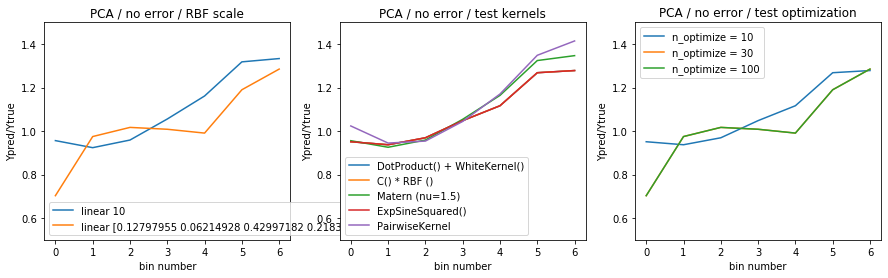

In [531]:
figure(figsize=(15,4))
Ytest_pca = pca.transform(Ytest)
######## test kernel
subplot(131)
for irbf in [10, Xstd]:#, 10]:
    kernel = C(1, (1e-3, 1e3)) * RBF(irbf, length_scale_bounds=(1e-2, 1e2)) 
    #### length scale up to 10 doesn't matter much
    #### 2nd numbers (1e-5, 1e5) don't seem to do anything
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)#, alpha=idY ** 2)
    gp.fit(Xtest, Ytest_pca)
    Ypred = pca.inverse_transform(gp.predict(Xtrue).ravel())
    plot(Ypred/Ytrue, label='linear %s'%(irbf))

title('PCA / no error / RBF scale')
xlabel('bin number')
ylabel('Ypred/Ytrue')
ylim(0.5, 1.5)
legend()

######## test kernel
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, Matern, ExpSineSquared, PairwiseKernel
kernels = [DotProduct() + WhiteKernel(),  C() * RBF (), Matern (nu=1.5), ExpSineSquared(),PairwiseKernel()]
kernel_names = ['DotProduct() + WhiteKernel()',  'C() * RBF ()', 'Matern (nu=1.5)', 'ExpSineSquared()', 'PairwiseKernel']
subplot(132)

for i in range(len(kernels)):
    ikernel = kernels[i]
    ikernel_name = kernel_names[i]
    gp = GaussianProcessRegressor(kernel=ikernel, n_restarts_optimizer=10, normalize_y=True)
    gp.fit(Xtest, Ytest_pca)
    Ypred = pca.inverse_transform(gp.predict(Xtrue).ravel())
    plot(Ypred/Ytrue, label='%s'%(ikernel_name))
    
title('PCA / no error / test kernels')
xlabel('bin number')
ylabel('Ypred/Ytrue')
ylim(0.5, 1.5)
legend()

####### test optimization -- doesn't matter
subplot(133)
for Nopt in [10, 30, 100]:
    kernel = C(1, (1e-3, 1e3)) * RBF(Xstd, length_scale_bounds=(1e-2, 1e2)) 
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=Nopt, normalize_y=True)#, alpha=idY ** 2)
    gp.fit(Xtest, Ytest_pca)
    Ypred = pca.inverse_transform(gp.predict(Xtrue).ravel())
    plot(Ypred/Ytrue, label='n_optimize = %s'%(Nopt))
    
    
title('PCA / no error / test optimization')
xlabel('bin number')
ylabel('Ypred/Ytrue')
ylim(0.5, 1.5)
legend()
show()

In [526]:
pca.transform(Ytest).shape

(25, 7)